In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import random
import numpy as np
import os
import argparse

SEED = 1000
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

from dataloader import DataLoader

NUM_CONV_LAYERS = 4
SAVE_INTERVAL = 100
LOG_INTERVAL = 1
VAL_INTERVAL = 50
NUM_TRAIN_TASKS = 20
NUM_TEST_TASKS = 100
NUM_ITERATIONS = 1500

In [19]:
tf.__version__

'2.9.0'

In [18]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10994889933476597083
xla_global_id: -1
]


In [2]:
num_classes, n_support, n_query = 5, 5, 15
num_inner_steps = 5
_outer_lr = 0.001
_inner_lr = 0.4

In [3]:
train_data = DataLoader('train', num_classes, n_support, n_query)
val_data = DataLoader('test', num_classes, n_support, n_query)

	-Preprocessing train Omniglot dataset
	-Preprocessing test Omniglot dataset


In [4]:
model_layers = [layers.Input(shape=(28,28,1))]

for i in range(NUM_CONV_LAYERS):
    model_layers.append(
        layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same", name=f"Conv{i+1}")
    )
    model_layers.append(
        layers.BatchNormalization(name=f"BN{i+1}")
    )
    model_layers.append(
        layers.ReLU(name=f"ReLU{i+1}")
    )
model_layers.append(layers.Flatten())
model_layers.append(layers.Dense(num_classes, activation='softmax', name='Classification'))
model = keras.Sequential(model_layers)

In [5]:
val_batches = val_data.generate_task(NUM_TEST_TASKS)

In [6]:
train_task = train_data.generate_task(NUM_TRAIN_TASKS)

## Outer 0

In [7]:
_optimizer = keras.optimizers.Adam(learning_rate=_outer_lr)

theta = tf.nest.map_structure(lambda x: tf.Variable(tf.zeros_like(x)), model.trainable_weights)
tf.nest.map_structure(lambda x, y: x.assign(y), theta, model.trainable_weights)

task_batch = train_task
for task in task_batch:
    support, query = task
    break

tf.Tensor([1 2 0 4 1 3 0 0 4 3 3 3 2 1 0 4 4 4 3 0 2 1 2 1 2], shape=(25,), dtype=int8)
tf.Tensor([0 2 3 0 4 4 4 2 0 2 3 4 0 2 3 3 1 4 0 1 1 2 3 1 1], shape=(25,), dtype=int8)
tf.Tensor([2 3 3 2 4 2 2 3 1 4 4 0 1 1 2 0 0 4 3 3 0 0 1 4 1], shape=(25,), dtype=int8)
tf.Tensor([1 2 0 1 3 4 2 0 2 0 4 2 4 0 0 3 4 4 1 3 1 3 3 2 1], shape=(25,), dtype=int8)
tf.Tensor([4 1 1 3 4 1 2 0 2 2 4 3 2 3 1 3 0 0 4 2 0 4 3 0 1], shape=(25,), dtype=int8)


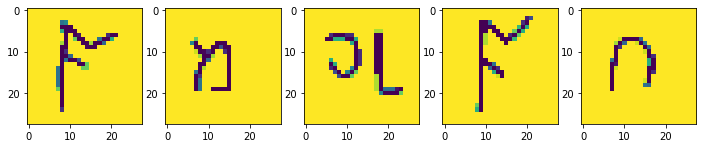

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(12, 10))
for i in range(5):
    imgs, label = support.take(1).get_single_element()
    axes[i].imshow(imgs[0].numpy().squeeze())
    print(label)

## Inner

In [9]:
def inner_run(theta, support_data):
    accuracies = []
    
    phi = tf.nest.map_structure(lambda x: tf.Variable(tf.zeros_like(x)), model.trainable_weights)
    tf.nest.map_structure(lambda x, y: x.assign(y), phi, theta)

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    opt_fn = tf.keras.optimizers.SGD(learning_rate=_inner_lr)
    metrics_fn = tf.keras.metrics.SparseCategoricalAccuracy(name='Inner Accuracy')
    for _ in range(num_inner_steps):
        for imgs, label in support_data:
            with tf.GradientTape() as tape:
                tape.watch(phi)
                logits = model(imgs, training=True)
                loss = loss_fn(label, logits)
            grads = tape.gradient(loss, model.trainable_weights)
            opt_fn.apply_gradients(zip(grads, phi))
            opt_fn.apply_gradients(zip(grads, model.trainable_weights))
            metrics_fn.update_state(label, logits)
            accuracies.append(metrics_fn.result().numpy())
    return phi, accuracies

In [10]:
phi, accuracies = inner_run(theta, support_data=support)

In [11]:
accuracies

[0.12, 0.24, 0.41333333, 0.43, 0.48]

## Outer 1

In [12]:
train = True

In [13]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
metrics_fn = tf.keras.metrics.SparseCategoricalAccuracy(name='Outer Accuracy')
all_grads = tf.nest.map_structure(lambda x: tf.Variable(tf.zeros_like(x)), model.trainable_weights)

outer_loss_batch = []
accuracies_support_batch = []
accuracy_query_batch = []

$$ \theta_{t+1} \coloneqq \theta_t - \beta \sum_{\tau_i \sim p(\tau)} \triangledown_\theta  L(\phi_i^L, D_i^{query})$$


$$\triangledown_\theta L(\phi_i^L, D_i^{query}) = \triangledown_{\phi_i^L} L(\phi_i^L, D_i^{query}) \cdot \prod_{k=1}^L (I - \alpha \triangledown_{\phi_i^{k-1}} (\triangledown_\theta L(\phi_i^{k-1}, D_i^{query}) ) ) $$

FO-MAML

$$\triangledown_\theta L(\phi_i^L, D_i^{query}) \approx \triangledown_{\phi_i^L} L(\phi_i^L, D_i^{query}) $$

In [14]:
for imgs, label in query:
    with tf.GradientTape(persistent=True) as tape:
        logits = model(imgs, training=train)
        loss = loss_fn(label, logits)
    break

In [15]:
model.trainable_weights[-1]

<tf.Variable 'Classification/bias:0' shape=(5,) dtype=float32, numpy=
array([ 0.00784224,  0.00637538, -0.00062185, -0.05236195,  0.03876615],
      dtype=float32)>

In [16]:
phi[-1]

<tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=
array([ 0.00784224,  0.00637538, -0.00062185, -0.05236195,  0.03876615],
      dtype=float32)>

In [17]:
tape.gradient(loss, phi)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [55]:
tape.gradient(loss, model.trainable_weights)

[<tf.Tensor: shape=(3, 3, 1, 64), dtype=float32, numpy=
 array([[[[-1.61054581e-02, -6.23244978e-03,  1.61026195e-02,
           -1.73617341e-02,  6.19814694e-02,  1.49341105e-02,
           -5.89688122e-03, -5.19816764e-04, -3.20043489e-02,
           -1.15482286e-02, -3.47858593e-02, -6.76340749e-03,
           -1.04968771e-02,  3.22401430e-03, -7.32299313e-03,
            2.52368376e-02,  4.89603244e-02, -4.09483016e-02,
           -1.16499700e-03, -4.59993482e-02,  5.25714830e-03,
            1.83833465e-02, -1.18395314e-03,  1.07855797e-02,
           -4.07252759e-02,  1.62493140e-02,  2.37308741e-02,
            3.54494900e-04,  1.58351455e-02, -3.06016915e-02,
            1.24053992e-02,  9.96745005e-03, -2.16446780e-02,
            4.35739420e-02, -3.52156535e-03, -5.43155670e-02,
           -3.51379290e-02,  5.12584671e-03, -1.42426789e-03,
           -3.97431068e-02,  1.07247122e-02,  7.01554120e-03,
           -9.52978581e-02, -2.28508711e-02,  8.30660574e-03,
           -1.

In [46]:
# in the batch loop
metrics_fn.reset_states()
task_loss = 0
num_batch_data = 0
task_grads = tf.nest.map_structure(lambda x: tf.Variable(tf.zeros_like(x)), model.trainable_weights)

for imgs, label in query:
    batch_size = len(label)
    with tf.GradientTape() as tape:
        logits = model(imgs, training=train)
        loss = loss_fn(label, logits)
    grads = tape.gradient(loss, model.trainable_weights)
    task_grads = tf.nest.map_structure(lambda x, y: x + y, task_grads, grads)
    task_loss += loss
    num_batch_data += batch_size
    metrics_fn.update_state(label, logits)

task_grads = [x / num_batch_data for x in task_grads]
accuracies_support_batch.append(accuracies)
accuracy_query_batch.append(metrics_fn.result().numpy())
outer_loss_batch.append(task_loss)

In [ ]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
all_grads = tf.nest.map_structure(lambda x: tf.Variable(tf.zeros_like(x)), self.model.trainable_weights)

for task in task_batch:
    support, query = task
    # support
    phi, accuracies = self._inner_loop(theta, support_data=support)
    # query
    metrics_fn.reset_states()
    query_loss = 0
    num_batch_data = 0
    task_grads = tf.nest.map_structure(lambda x: tf.Variable(tf.zeros_like(x)), self.model.trainable_weights)

    for imgs, label in query:
        batch_size = len(label)
        with tf.GradientTape() as tape:
            logits = self.model(imgs, training=train)
            loss = loss_fn(label, logits)
        grads = tape.gradient(loss, self.model.trainable_weights)
        task_grads = tf.nest.map_structure(lambda x, y: x + y, task_grads, grads)
        query_loss += loss
        num_batch_data += batch_size
        metrics_fn.update_state(label, logits)

    task_grads = [x / num_batch_data for x in task_grads]
    all_grads = tf.nest.map_structure(lambda x, y: x + y, task_grads, all_grads)
    accuracies_support_batch.append(accuracies)
    accuracy_query_batch.append(metrics_fn.result().numpy())
    outer_loss_batch.append(query_loss)

self._optimizer.apply_gradients(zip(all_grads, theta))

In [ ]:
all_grads = tf.nest.map_structure(lambda x, y: x + y, task_grads, all_grads)

In [31]:
_optimizer.apply_gradients(zip(all_grads, theta))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=2>

In [ ]:
dataset = train_data.generate_entire_dataset()